In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### visualize data

In [2]:
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize = (5,5))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

### read data

In [3]:
data = pd.read_csv('sonar.all-data', header=None)
data.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60
0,0.0200,0.0371,0.0428,0.0207,0.0954,0.0986,0.1539,0.1601,0.3109,0.2111,0.1609,0.1582,0.2238,0.0645,0.0660,0.2273,0.3100,0.2999,0.5078,0.4797,0.5783,0.5071,0.4328,0.5550,0.6711,0.6415,0.7104,0.8080,0.6791,0.3857,0.1307,0.2604,0.5121,0.7547,0.8537,0.8507,0.6692,0.6097,0.4943,0.2744,0.0510,0.2834,0.2825,0.4256,0.2641,0.1386,0.1051,0.1343,0.0383,0.0324,0.0232,0.0027,0.0065,0.0159,0.0072,0.0167,0.0180,0.0084,0.0090,0.0032,R
1,0.0453,0.0523,0.0843,0.0689,0.1183,0.2583,0.2156,0.3481,0.3337,0.2872,0.4918,0.6552,0.6919,0.7797,0.7464,0.9444,1.0000,0.8874,0.8024,0.7818,0.5212,0.4052,0.3957,0.3914,0.3250,0.3200,0.3271,0.2767,0.4423,0.2028,0.3788,0.2947,0.1984,0.2341,0.1306,0.4182,0.3835,0.1057,0.1840,0.1970,0.1674,0.0583,0.1401,0.1628,0.0621,0.0203,0.0530,0.0742,0.0409,0.0061,0.0125,0.0084,0.0089,0.0048,0.0094,0.0191,0.0140,0.0049,0.0052,0.0044,R
2,0.0262,0.0582,0.1099,0.1083,0.0974,0.2280,0.2431,0.3771,0.5598,0.6194,0.6333,0.7060,0.5544,0.5320,0.6479,0.6931,0.6759,0.7551,0.8929,0.8619,0.7974,0.6737,0.4293,0.3648,0.5331,0.2413,0.5070,0.8533,0.6036,0.8514,0.8512,0.5045,0.1862,0.2709,0.4232,0.3043,0.6116,0.6756,0.5375,0.4719,0.4647,0.2587,0.2129,0.2222,0.2111,0.0176,0.1348,0.0744,0.0130,0.0106,0.0033,0.0232,0.0166,0.0095,0.0180,0.0244,0.0316,0.0164,0.0095,0.0078,R
3,0.0100,0.0171,0.0623,0.0205,0.0205,0.0368,0.1098,0.1276,0.0598,0.1264,0.0881,0.1992,0.0184,0.2261,0.1729,0.2131,0.0693,0.2281,0.4060,0.3973,0.2741,0.3690,0.5556,0.4846,0.3140,0.5334,0.5256,0.2520,0.2090,0.3559,0.6260,0.7340,0.6120,0.3497,0.3953,0.3012,0.5408,0.8814,0.9857,0.9167,0.6121,0.5006,0.3210,0.3202,0.4295,0.3654,0.2655,0.1576,0.0681,0.0294,0.0241,0.0121,0.0036,0.0150,0.0085,0.0073,0.0050,0.0044,0.0040,0.0117,R
4,0.0762,0.0666,0.0481,0.0394,0.0590,0.0649,0.1209,0.2467,0.3564,0.4459,0.4152,0.3952,0.4256,0.4135,0.4528,0.5326,0.7306,0.6193,0.2032,0.4636,0.4148,0.4292,0.5730,0.5399,0.3161,0.2285,0.6995,1.0000,0.7262,0.4724,0.5103,0.5459,0.2881,0.0981,0.1951,0.4181,0.4604,0.3217,0.2828,0.2430,0.1979,0.2444,0.1847,0.0841,0.0692,0.0528,0.0357,0.0085,0.0230,0.0046,0.0156,0.0031,0.0054,0.0105,0.0110,0.0015,0.0072,0.0048,0.0107,0.0094,R


### train val test split

In [4]:
y_dict = {1:'R', 0:'M'}
y = np.array([int(i == 'R') for i in list(data[60])])
X = data.drop(columns=[60], axis=1)

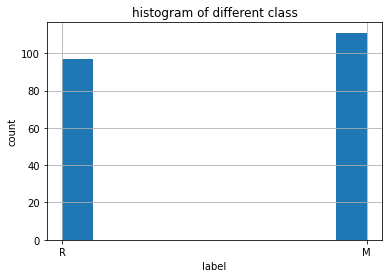

In [5]:
data[60].hist()
plt.title('histogram of different class')
plt.xlabel('label')
plt.ylabel('count')
plt.show()

#### stratified_sample, aspect angle dependent

the random splits gave poor results, presumably because the test set contains some samples from aspect angles that are under-represented in the corresponding training set. This motivated Gorman
and Sejnowski to devise a different set of experiments in which an attempt was made to balance the training and test sets so that each would have a representative number of samples from all aspect angles. Since detailed aspect angle information was not present in the data base of samples, the 208 samples were first divided into clusters, using a 60-dimensional
Euclidian metric; each of these clusters was then divided between the 80% training set and the 20% test set. each of these clusters for train data was then divided between the 80% training set and the 20% validation set. 

In [6]:
import warnings
warnings.filterwarnings("ignore")

def stratified_sample(df, strata, size=0.2, seed=42, keep_index= True):
    population = len(df)
    size = smpl_size(population, size)
    tmp = df[strata]
    tmp['size'] = 1
    tmp_grpd = tmp.groupby(strata).count().reset_index()
    tmp_grpd['samp_size'] = round(size/population * tmp_grpd['size']).astype(int)

    # controlling variable to create the dataframe or append to it
    first = True 
    for i in range(len(tmp_grpd)):
        # query generator for each iteration
        qry=''
        for s in range(len(strata)):
            stratum = strata[s]
            value = tmp_grpd.iloc[i][stratum]
            n = tmp_grpd.iloc[i]['samp_size']

            if type(value) == str:
                value = "'" + str(value) + "'"
            
            if s != len(strata)-1:
                qry = qry + stratum + ' == ' + str(value) +' & '
            else:
                qry = qry + stratum + ' == ' + str(value)
        
        # final dataframe
        if first:
            stratified_df = df.query(qry).sample(n=n, random_state=seed).reset_index(drop=(not keep_index))
            first = False
        else:
            tmp_df = df.query(qry).sample(n=n, random_state=seed).reset_index(drop=(not keep_index))
            stratified_df = stratified_df.append(tmp_df, ignore_index=True)
    
    return stratified_df



def stratified_sample_report(df, strata, size=0.2):
    population = len(df)
    size = smpl_size(population, size)
    tmp = df[strata]
    tmp['size'] = 1
    tmp_grpd = tmp.groupby(strata).count().reset_index()
    tmp_grpd['samp_size'] = round(size/population * tmp_grpd['size']).astype(int)
    return tmp_grpd


def smpl_size(population, size):
    return round(population * size)

#### find best k for kmeans with silhouette_score

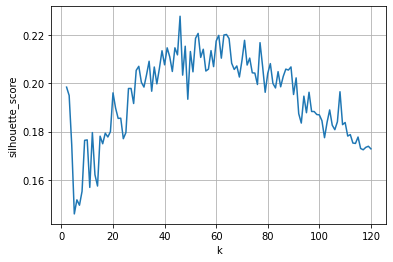

best k =  46


In [7]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

sil = []
kmax = 120

# dissimilarity would not be defined for a single cluster, thus, minimum number of clusters should be 2
for k in range(2, kmax+1):
  kmeans = KMeans(n_clusters = k).fit(X)
  labels = kmeans.labels_
  sil.append(silhouette_score(X, labels, metric = 'euclidean'))

plt.plot(range(2, kmax+1), sil)
plt.xlabel('k')
plt.ylabel('silhouette_score')
plt.grid()
plt.show()
print('best k = ', np.argmax(np.array(sil))+2)

global maximum at the optimal k.

#### find best k elbow

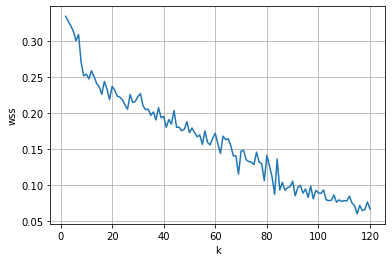

best k =  115


In [8]:
from sklearn.cluster import KMeans

# function returns WSS score for k values from 1 to kmax
def calculate_WSS(points, kmax):
  sse = []
  for k in range(2, kmax+1):
    kmeans = KMeans(n_clusters = k).fit(points)
    centroids = kmeans.cluster_centers_
    pred_clusters = kmeans.predict(points)
    curr_sse = 0
    
    # calculate square of Euclidean distance of each point from its cluster center and add to current WSS
    for i in range(len(points)):
      curr_center = centroids[pred_clusters[i]]
      curr_sse += (points[i, 0] - curr_center[0]) ** 2 + (points[i, 1] - curr_center[1]) ** 2
      
    sse.append(curr_sse)
  return sse

sse = calculate_WSS(X.to_numpy(), 120)
plt.plot(range(2, 120+1), sse)
plt.xlabel('k')
plt.ylabel('wss')
plt.grid()
plt.show()
print('best k = ', np.argmin(np.array(sse))+2)

In [9]:
kmeans = KMeans(n_clusters = 25, random_state=42).fit(X)
X['cluster_n'] = kmeans.labels_

In [10]:
print(stratified_sample_report(X, ['cluster_n'], size=0.5))
X_train = stratified_sample(X, ['cluster_n'], size=0.5, seed=42, keep_index= True)
y_train = y[X_train['index']]
Xtv = X.drop(X_train['index'])
print(stratified_sample_report(Xtv, ['cluster_n'], size=0.5))
X_val = stratified_sample(Xtv, ['cluster_n'], size=0.5, seed=42, keep_index= True)
y_val = y[X_val['index']]
X_test = Xtv.drop(X_val['index'])
y_test = np.delete(y, np.concatenate((X_val['index'], X_train['index']), axis=0))

    cluster_n  size  samp_size
0           0    14          7
1           1    16          8
2           2     7          4
3           3     7          4
4           4    13          6
5           5     6          3
6           6     8          4
7           7     6          3
8           8     6          3
9           9     7          4
10         10    10          5
11         11     9          4
12         12     5          2
13         13     5          2
14         14     4          2
15         15    10          5
16         16     6          3
17         17     7          4
18         18     7          4
19         19    21         10
20         20     5          2
21         21     4          2
22         22     9          4
23         23    12          6
24         24     4          2
    cluster_n  size  samp_size
0           0     7          3
1           1     8          4
2           2     3          1
3           3     3          1
4           4     7          3
5       

In [11]:
X_train = X_train.drop(columns=['cluster_n', 'index'], axis=1)
X_val = X_val.drop(columns=['cluster_n', 'index'], axis=1)
X_test = X_test.drop(columns=['cluster_n'], axis=1)

In [12]:
train = X_train.copy(deep=True)
train[60] = y_train
train.to_csv('Q2train.csv', index=False)
val = X_val.copy(deep=True)
val[60] = y_val
val.to_csv('Q2val.csv', index=False)
test = X_test.copy(deep=True)
test[60] = y_test
test.to_csv('Q2test.csv', index=False)

#### random split

In [13]:
# from sklearn.model_selection import train_test_split

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

### StandardScaler

In [14]:
from sklearn.preprocessing import StandardScaler
ss= StandardScaler()

X_train = ss.fit_transform(X_train)
X_val = ss.fit_transform(X_val)
X_test = ss.fit_transform(X_test)

### convert labels to one-hot vectors

In [15]:
from keras.utils import np_utils
y_train = np_utils.to_categorical(y_train)
y_test_copy = y_test.copy()
y_test = np_utils.to_categorical(y_test)
y_val = np_utils.to_categorical(y_val)

### classification

In [16]:
from keras.models import Sequential
from keras.utils import np_utils
from keras.layers.core import Dense

def model_base(act, nl):
  model = Sequential()
  model.add(Dense(48, activation=act, input_shape=(60,)))	#Hidden Layer 1
  model.add(Dense(24, activation=act))	#Hidden Layer 2
  for i in range(nl):
    model.add(Dense(12/(i+1), activation=act))	#Hidden Layer 3
  model.add(Dense(2, activation='softmax')) #Last layer with one output per class
  model.summary()

  # Configure the Network
  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
  return model

model = model_base('relu', 0)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 48)                2928      
_________________________________________________________________
dense_1 (Dense)              (None, 24)                1176      
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 50        
Total params: 4,154
Trainable params: 4,154
Non-trainable params: 0
_________________________________________________________________


In [17]:
def plot_metrics(history, title):
  # Plotting Metrics
  # Plot the Accuracy Curves
  fig = plt.figure()
  plt.plot(history.history['accuracy'],'r')
  plt.plot(history.history['val_accuracy'],'b')
  plt.title('model accuracy '+str(title))
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'validation'], loc='lower right')
  plt.grid()

  # Plot the Loss Curves
  fig = plt.figure()
  plt.plot(history.history['loss'],'r')
  plt.plot(history.history['val_loss'],'b')
  plt.title('model loss '+str(title))
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'validation'], loc='upper right')
  plt.grid()

Epoch 1/400
4/4 [==============================] - 1s 182ms/step - loss: 0.7671 - accuracy: 0.4967 - val_loss: 0.6617 - val_accuracy: 0.5814

Epoch 00001: val_loss improved from inf to 0.66175, saving model to model_best_weights.h5
Epoch 2/400
4/4 [==============================] - 0s 19ms/step - loss: 0.6530 - accuracy: 0.6714 - val_loss: 0.6044 - val_accuracy: 0.6512

Epoch 00002: val_loss improved from 0.66175 to 0.60443, saving model to model_best_weights.h5
Epoch 3/400
4/4 [==============================] - 0s 21ms/step - loss: 0.5860 - accuracy: 0.6897 - val_loss: 0.5626 - val_accuracy: 0.7442

Epoch 00003: val_loss improved from 0.60443 to 0.56262, saving model to model_best_weights.h5
Epoch 4/400
4/4 [==============================] - 0s 22ms/step - loss: 0.5456 - accuracy: 0.7435 - val_loss: 0.5288 - val_accuracy: 0.7674

Epoch 00004: val_loss improved from 0.56262 to 0.52876, saving model to model_best_weights.h5
Epoch 5/400
4/4 [==============================] - 0s 18ms/step

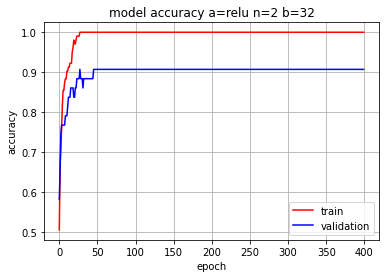

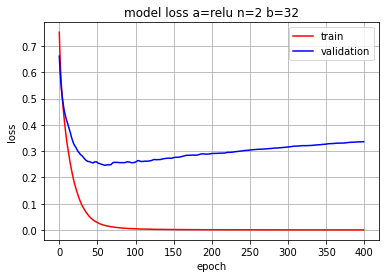

In [18]:
from keras.callbacks import ModelCheckpoint

def fit_model(model, X_train, y_train, X_val, y_val, name, v, bsize=32, title=''):
  checkpoint = ModelCheckpoint(name, monitor='val_loss', verbose=v,
                              save_best_only=True, mode='min')
  history = model.fit(X_train, y_train, epochs=400, batch_size=bsize, validation_data=(X_val, y_val),
                      verbose=v, callbacks=[checkpoint])
  plot_metrics(history, title)
  return model

model = fit_model(model, X_train, y_train, X_val, y_val, "model_best_weights.h5", 1, bsize=32, title='a=relu n=2 b=32')

2/2 [==============================] - 0s 6ms/step - loss: 0.5469 - accuracy: 0.7880
Test Loss 0.4573431611061096
Test Accuracy 0.8225806355476379
              precision    recall  f1-score   support

           0       0.83      0.86      0.85        35
           1       0.81      0.78      0.79        27

    accuracy                           0.82        62
   macro avg       0.82      0.82      0.82        62
weighted avg       0.82      0.82      0.82        62

f1 0.8187616263619453
precision 0.8205128205128205
recall 0.8174603174603174
accuracy 0.8225806451612904


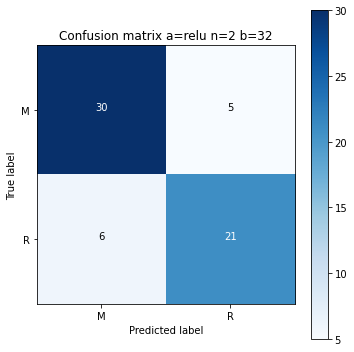

In [19]:
from sklearn.metrics import confusion_matrix , classification_report
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score

def eval_model(model, X_test, y_test, weights_name, title=''):
  # load weights
  model.load_weights(weights_name)
  # Compile model (required to make predictions)
  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

  # Prediction Labels
  y_pred = model.predict(X_test)
  y_pred = np.argmax(y_pred, axis=1)

  # Evaluate the trained model
  [test_loss, test_acc] = model.evaluate(X_test, y_test)
  print("Test Loss", test_loss)
  print("Test Accuracy", test_acc)
  # Confusion Matrix
  class_names=['M','R']
  confusion_mtx = confusion_matrix(y_test_copy, y_pred)
      
  plot_confusion_matrix(confusion_mtx, class_names, title='Confusion matrix '+str(title))    

  print(classification_report(y_test_copy,y_pred))
  print('f1', f1_score(y_test_copy, y_pred, average='macro'))
  print('precision', precision_score(y_test_copy, y_pred, average='macro'))
  print('recall', recall_score(y_test_copy, y_pred, average='macro'))
  print('accuracy', accuracy_score(y_test_copy, y_pred))

eval_model(model, X_test, y_test, "model_best_weights.h5", 'a=relu n=2 b=32')

### batch size 64, 128

#### 64

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 48)                2928      
_________________________________________________________________
dense_4 (Dense)              (None, 24)                1176      
_________________________________________________________________
dense_5 (Dense)              (None, 2)                 50        
Total params: 4,154
Trainable params: 4,154
Non-trainable params: 0
_________________________________________________________________
Epoch 1/400
2/2 [==============================] - 1s 211ms/step - loss: 0.9391 - accuracy: 0.4941 - val_loss: 0.9244 - val_accuracy: 0.4651

Epoch 00001: val_loss improved from inf to 0.92440, saving model to model_best_weights64.h5
Epoch 2/400
2/2 [==============================] - 0s 55ms/step - loss: 0.8068 - accuracy: 0.4863 - val_loss: 0.8480 - val_accuracy: 0.4651

Epoch 0

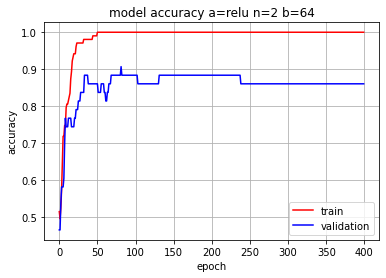

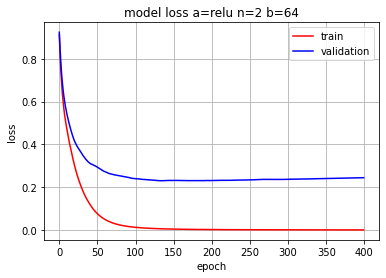

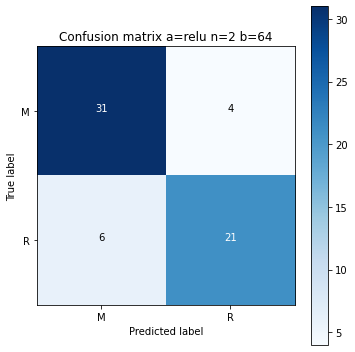

In [20]:
model = model_base('relu', 0)
model = fit_model(model, X_train, y_train, X_val, y_val, "model_best_weights64.h5", 1, bsize=64, title='a=relu n=2 b=64')
eval_model(model, X_test, y_test, "model_best_weights64.h5", 'a=relu n=2 b=64')

####128

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 48)                2928      
_________________________________________________________________
dense_7 (Dense)              (None, 24)                1176      
_________________________________________________________________
dense_8 (Dense)              (None, 2)                 50        
Total params: 4,154
Trainable params: 4,154
Non-trainable params: 0
_________________________________________________________________
Epoch 1/400
1/1 [==============================] - 1s 580ms/step - loss: 0.7990 - accuracy: 0.4563 - val_loss: 0.8325 - val_accuracy: 0.4186

Epoch 00001: val_loss improved from inf to 0.83252, saving model to model_best_weights64.h5
Epoch 2/400
1/1 [==============================] - 0s 63ms/step - loss: 0.7537 - accuracy: 0.4466 - val_loss: 0.7958 - val_accuracy: 0.4651

Epoch 0

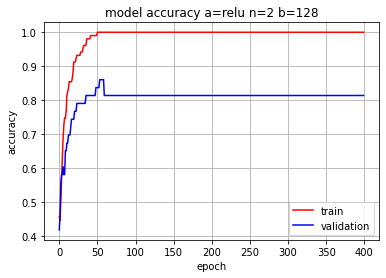

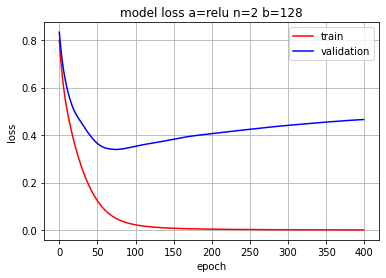

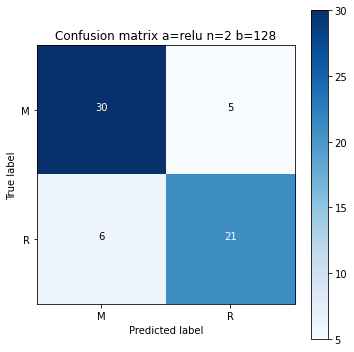

In [21]:
model = model_base('relu', 0)
model = fit_model(model, X_train, y_train, X_val, y_val, "model_best_weights64.h5", 1, bsize=128, title='a=relu n=2 b=128')
eval_model(model, X_test, y_test, "model_best_weights64.h5", 'a=relu n=2 b=128')

best batch size 64 for best metric.

### compare activation function

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 48)                2928      
_________________________________________________________________
dense_10 (Dense)             (None, 24)                1176      
_________________________________________________________________
dense_11 (Dense)             (None, 2)                 50        
Total params: 4,154
Trainable params: 4,154
Non-trainable params: 0
_________________________________________________________________
Epoch 1/400
4/4 [==============================] - 1s 142ms/step - loss: 0.5877 - accuracy: 0.7171 - val_loss: 0.5407 - val_accuracy: 0.6744

Epoch 00001: val_loss improved from inf to 0.54070, saving model to model_best_weightst128.h5
Epoch 2/400
4/4 [==============================] - 0s 18ms/step - loss: 0.5097 - accuracy: 0.7875 - val_loss: 0.5027 - val_accuracy: 0.6744

Epoch

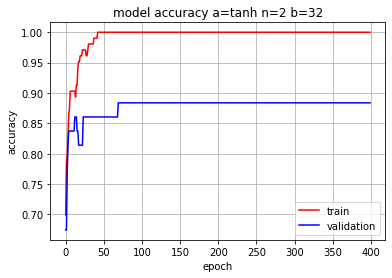

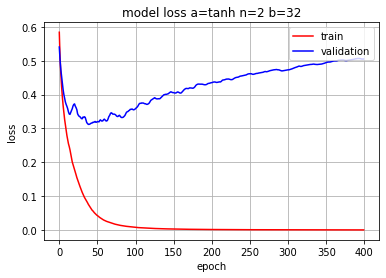

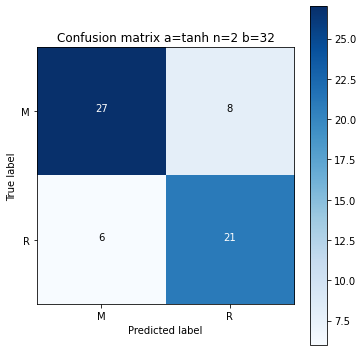

In [22]:
model = model_base('tanh', 0)
model = fit_model(model, X_train, y_train, X_val, y_val, "model_best_weightst128.h5", 1, bsize=32, title='a=tanh n=2 b=32')
eval_model(model, X_test, y_test, "model_best_weightst128.h5", 'a=tanh n=2 b=32')

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (None, 48)                2928      
_________________________________________________________________
dense_13 (Dense)             (None, 24)                1176      
_________________________________________________________________
dense_14 (Dense)             (None, 2)                 50        
Total params: 4,154
Trainable params: 4,154
Non-trainable params: 0
_________________________________________________________________
Epoch 1/400
2/2 [==============================] - 1s 228ms/step - loss: 0.7327 - accuracy: 0.5421 - val_loss: 0.6956 - val_accuracy: 0.5814

Epoch 00001: val_loss improved from inf to 0.69558, saving model to model_best_weightst128.h5
Epoch 2/400
2/2 [==============================] - 0s 55ms/step - loss: 0.6244 - accuracy: 0.6213 - val_loss: 0.6423 - val_accuracy: 0.6047

Epoch

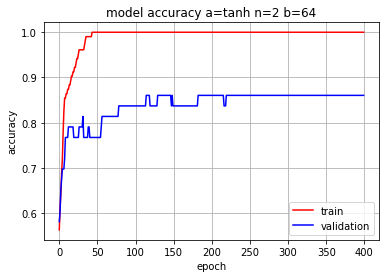

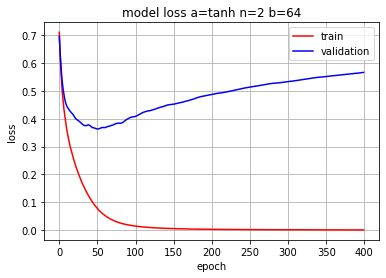

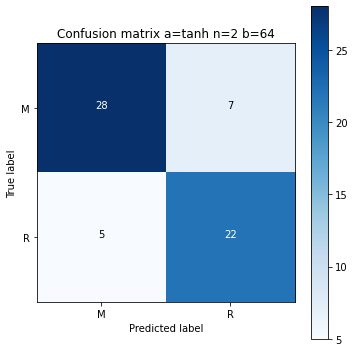

In [23]:
model = model_base('tanh', 0)
model = fit_model(model, X_train, y_train, X_val, y_val, "model_best_weightst128.h5", 1, bsize=64, title='a=tanh n=2 b=64')
eval_model(model, X_test, y_test, "model_best_weightst128.h5", 'a=tanh n=2 b=64')

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_15 (Dense)             (None, 48)                2928      
_________________________________________________________________
dense_16 (Dense)             (None, 24)                1176      
_________________________________________________________________
dense_17 (Dense)             (None, 2)                 50        
Total params: 4,154
Trainable params: 4,154
Non-trainable params: 0
_________________________________________________________________
Epoch 1/400
1/1 [==============================] - 1s 586ms/step - loss: 0.9021 - accuracy: 0.4272 - val_loss: 0.7694 - val_accuracy: 0.4651

Epoch 00001: val_loss improved from inf to 0.76941, saving model to model_best_weightst128.h5
Epoch 2/400
1/1 [==============================] - 0s 56ms/step - loss: 0.8419 - accuracy: 0.4757 - val_loss: 0.7269 - val_accuracy: 0.5116

Epoch

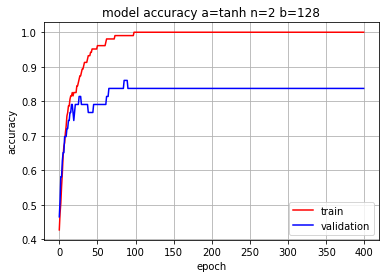

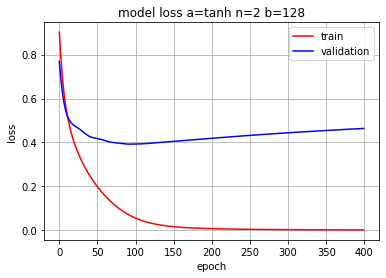

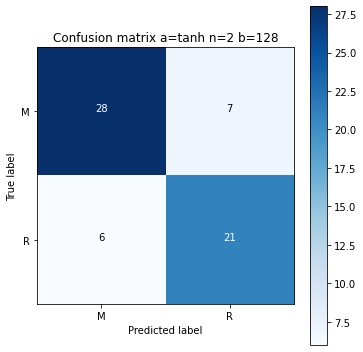

In [24]:
model = model_base('tanh', 0)
model = fit_model(model, X_train, y_train, X_val, y_val, "model_best_weightst128.h5", 1, bsize=128, title='a=tanh n=2 b=128')
eval_model(model, X_test, y_test, "model_best_weightst128.h5", 'a=tanh n=2 b=128')

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_18 (Dense)             (None, 48)                2928      
_________________________________________________________________
dense_19 (Dense)             (None, 24)                1176      
_________________________________________________________________
dense_20 (Dense)             (None, 2)                 50        
Total params: 4,154
Trainable params: 4,154
Non-trainable params: 0
_________________________________________________________________
Epoch 1/400
4/4 [==============================] - 1s 74ms/step - loss: 0.6794 - accuracy: 0.5352 - val_loss: 0.6576 - val_accuracy: 0.7209

Epoch 00001: val_loss improved from inf to 0.65759, saving model to model_best_weightss128.h5
Epoch 2/400
4/4 [==============================] - 0s 19ms/step - loss: 0.6655 - accuracy: 0.6682 - val_loss: 0.6449 - val_accuracy: 0.7209

Epoch 

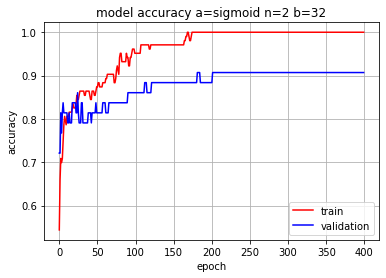

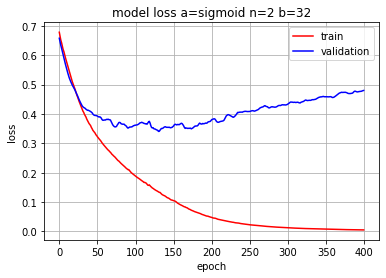

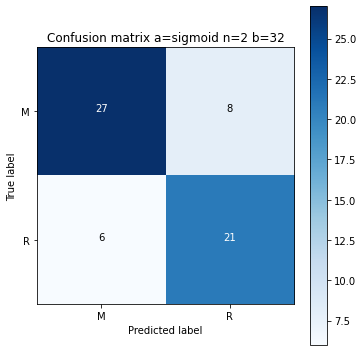

In [25]:
model = model_base('sigmoid', 0)
model = fit_model(model, X_train, y_train, X_val, y_val, "model_best_weightss128.h5", 1, bsize=32, title='a=sigmoid n=2 b=32')
eval_model(model, X_test, y_test, "model_best_weightss128.h5", 'a=sigmoid n=2 b=32')

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_21 (Dense)             (None, 48)                2928      
_________________________________________________________________
dense_22 (Dense)             (None, 24)                1176      
_________________________________________________________________
dense_23 (Dense)             (None, 2)                 50        
Total params: 4,154
Trainable params: 4,154
Non-trainable params: 0
_________________________________________________________________
Epoch 1/400
2/2 [==============================] - 1s 240ms/step - loss: 0.6933 - accuracy: 0.4267 - val_loss: 0.6850 - val_accuracy: 0.5349

Epoch 00001: val_loss improved from inf to 0.68501, saving model to model_best_weightss128.h5
Epoch 2/400
2/2 [==============================] - 0s 66ms/step - loss: 0.6867 - accuracy: 0.4772 - val_loss: 0.6770 - val_accuracy: 0.5814

Epoch

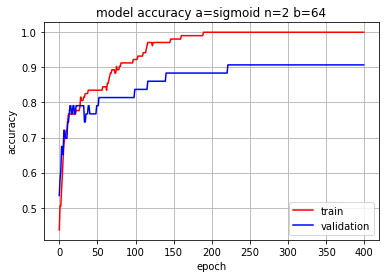

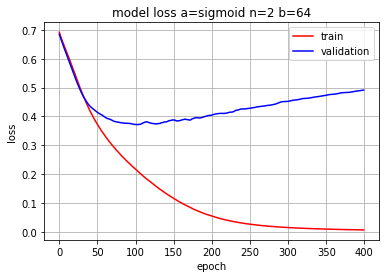

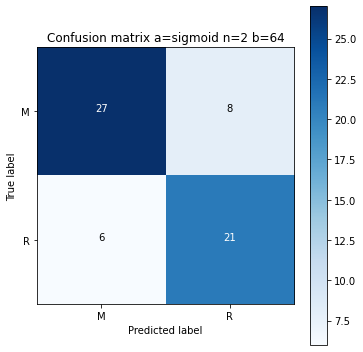

In [26]:
model = model_base('sigmoid', 0)
model = fit_model(model, X_train, y_train, X_val, y_val, "model_best_weightss128.h5", 1, bsize=64, title='a=sigmoid n=2 b=64')
eval_model(model, X_test, y_test, "model_best_weightss128.h5", 'a=sigmoid n=2 b=64')

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_24 (Dense)             (None, 48)                2928      
_________________________________________________________________
dense_25 (Dense)             (None, 24)                1176      
_________________________________________________________________
dense_26 (Dense)             (None, 2)                 50        
Total params: 4,154
Trainable params: 4,154
Non-trainable params: 0
_________________________________________________________________
Epoch 1/400
1/1 [==============================] - 1s 574ms/step - loss: 0.8607 - accuracy: 0.4757 - val_loss: 0.8338 - val_accuracy: 0.4884

Epoch 00001: val_loss improved from inf to 0.83385, saving model to model_best_weightss128.h5
Epoch 2/400
1/1 [==============================] - 0s 50ms/step - loss: 0.8385 - accuracy: 0.4757 - val_loss: 0.8134 - val_accuracy: 0.4884

Epoch

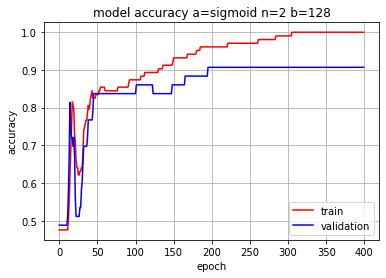

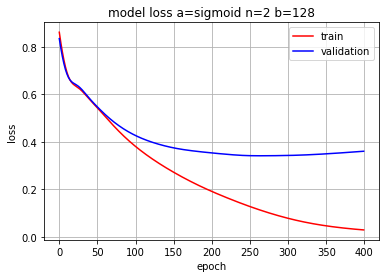

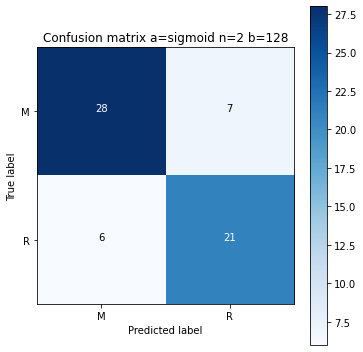

In [27]:
model = model_base('sigmoid', 0)
model = fit_model(model, X_train, y_train, X_val, y_val, "model_best_weightss128.h5", 1, bsize=128, title='a=sigmoid n=2 b=128')
eval_model(model, X_test, y_test, "model_best_weightss128.h5", 'a=sigmoid n=2 b=128')

### more hidden layer

relu 0 32
Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_27 (Dense)             (None, 48)                2928      
_________________________________________________________________
dense_28 (Dense)             (None, 24)                1176      
_________________________________________________________________
dense_29 (Dense)             (None, 2)                 50        
Total params: 4,154
Trainable params: 4,154
Non-trainable params: 0
_________________________________________________________________
2/2 [==============================] - 0s 6ms/step - loss: 0.5316 - accuracy: 0.7772
Test Loss 0.46636536717414856
Test Accuracy 0.8064516186714172
              precision    recall  f1-score   support

           0       0.79      0.89      0.84        35
           1       0.83      0.70      0.76        27

    accuracy                           0.81        62
   mac

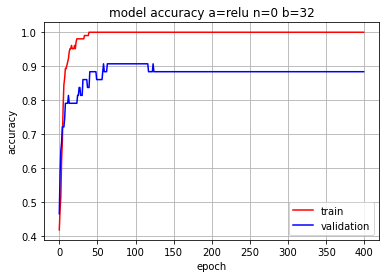

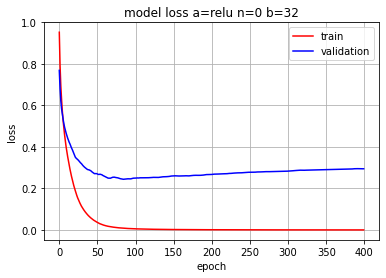

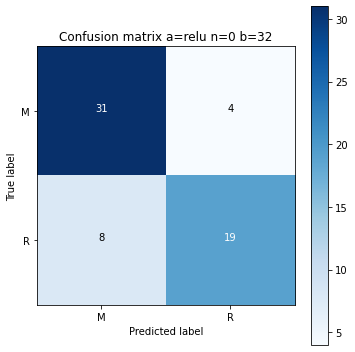

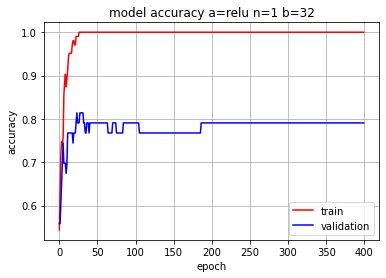

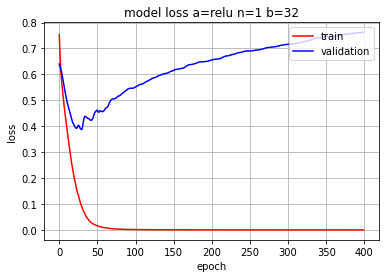

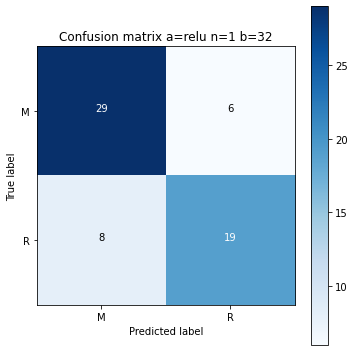

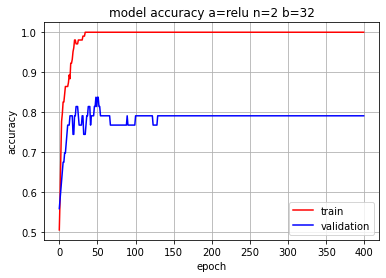

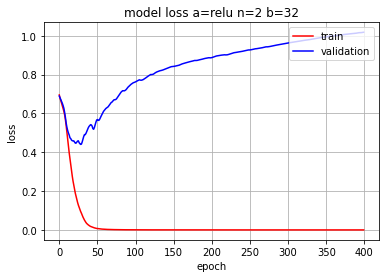

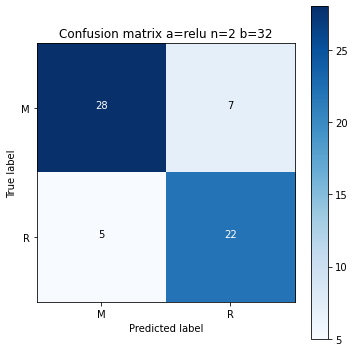

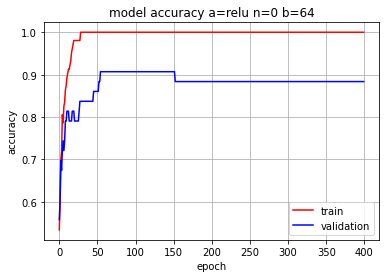

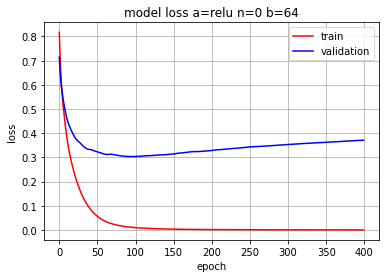

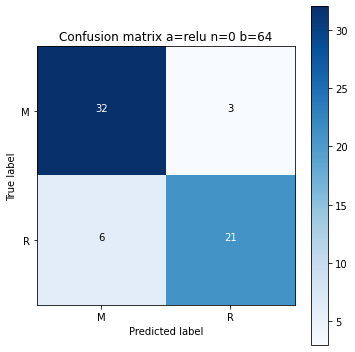

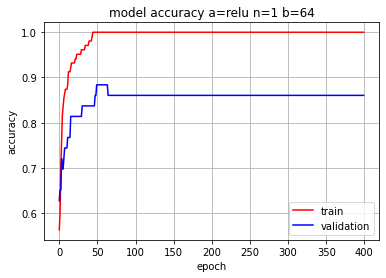

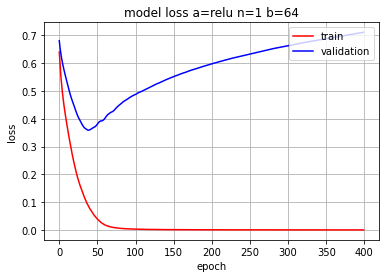

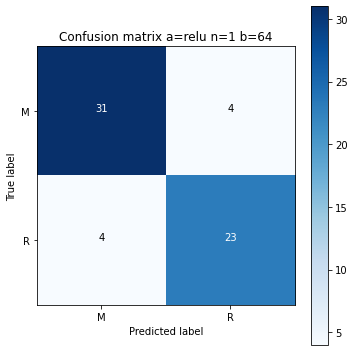

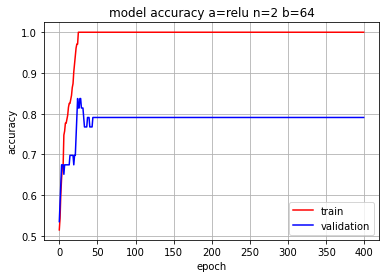

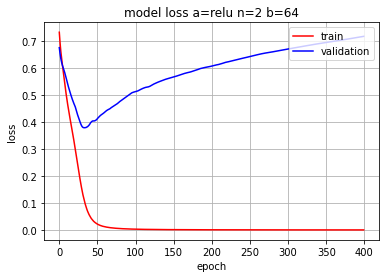

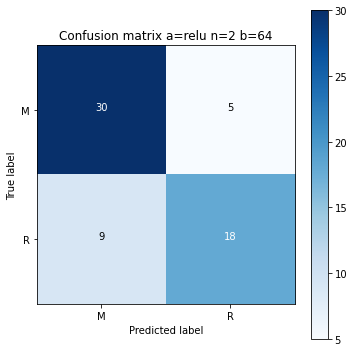

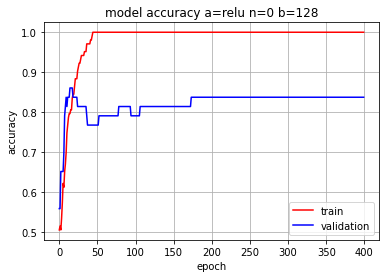

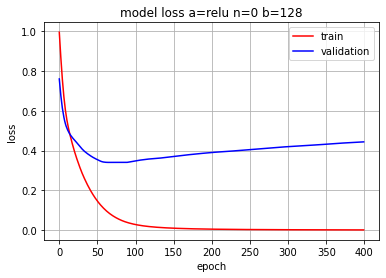

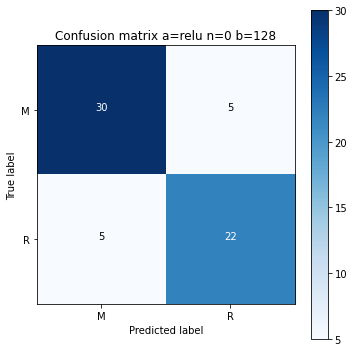

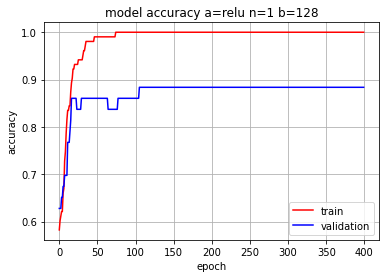

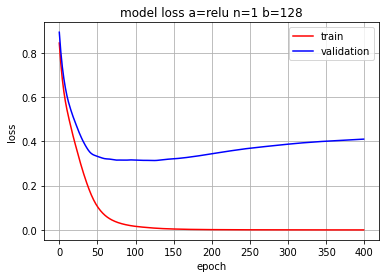

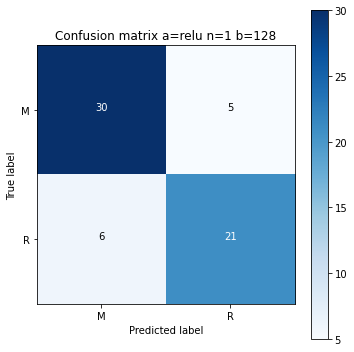

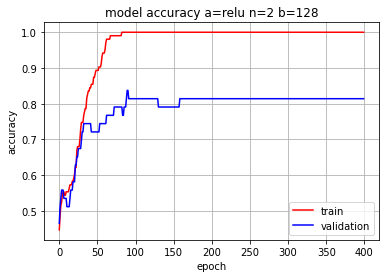

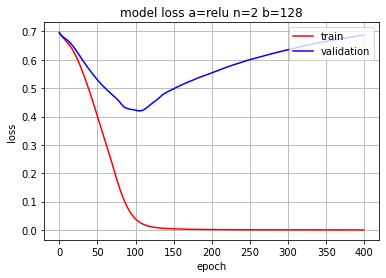

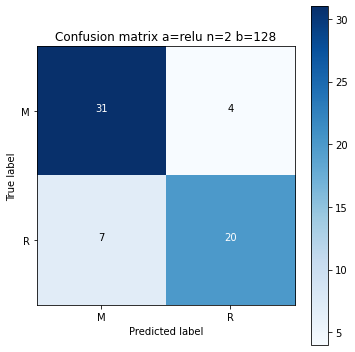

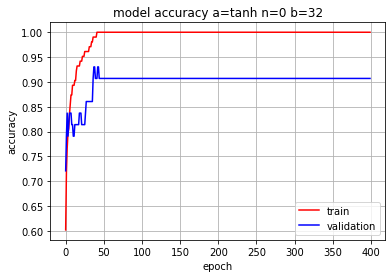

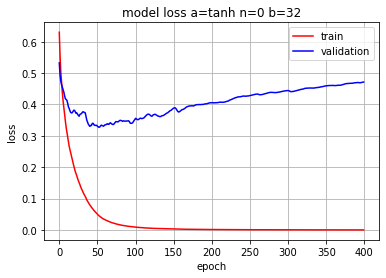

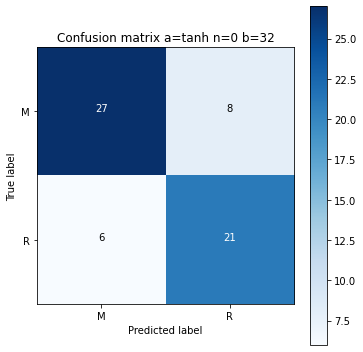

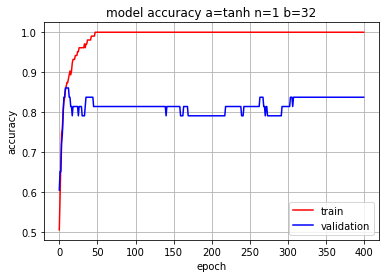

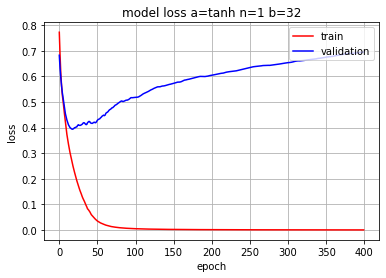

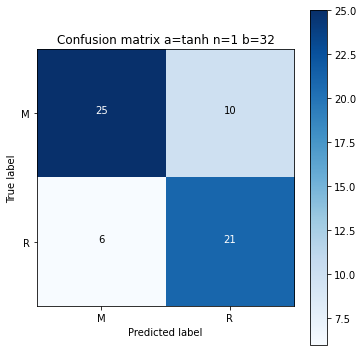

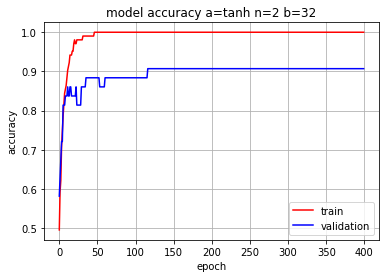

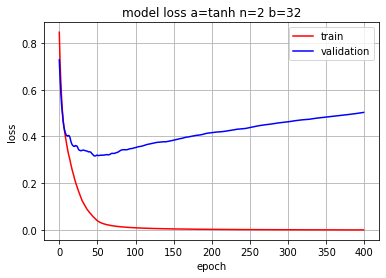

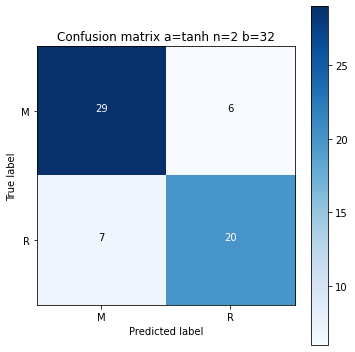

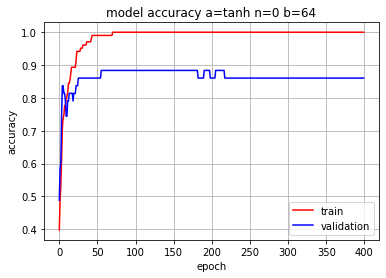

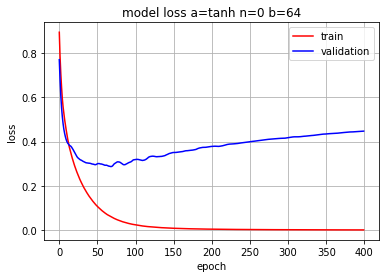

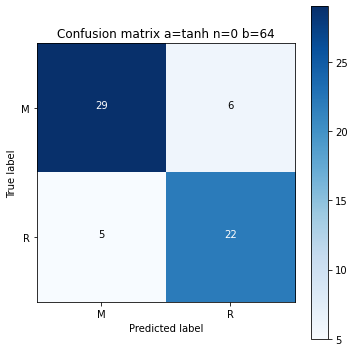

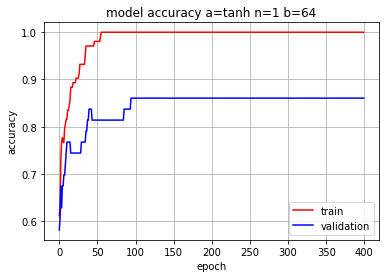

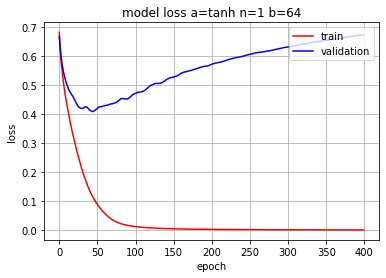

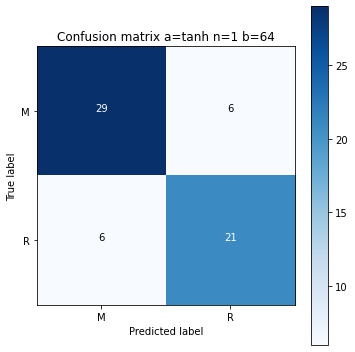

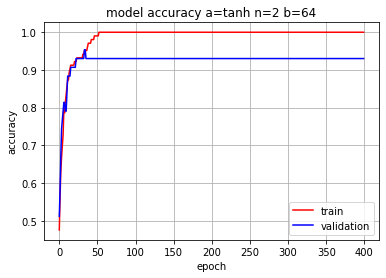

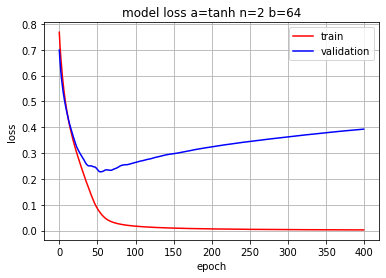

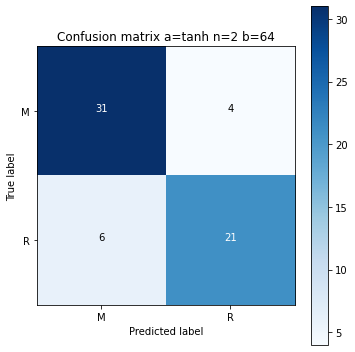

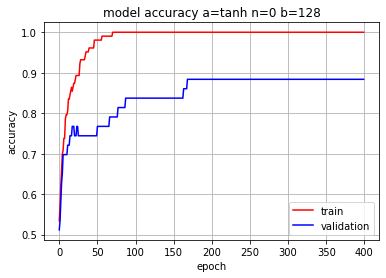

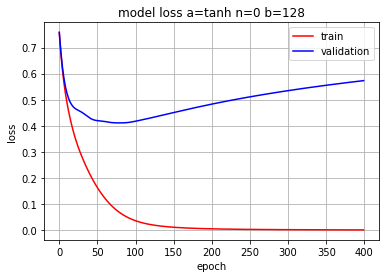

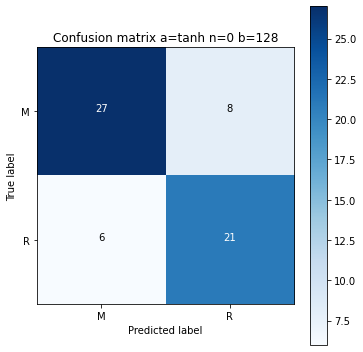

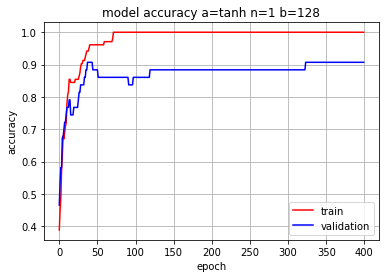

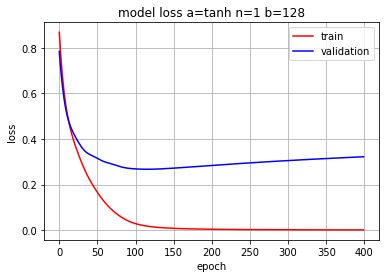

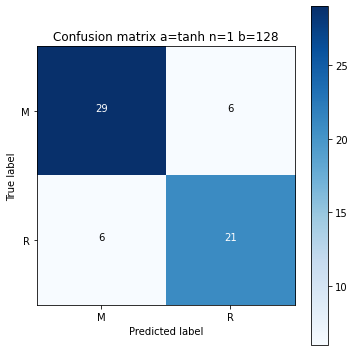

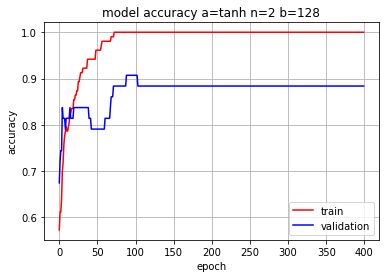

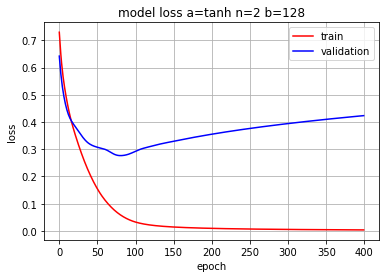

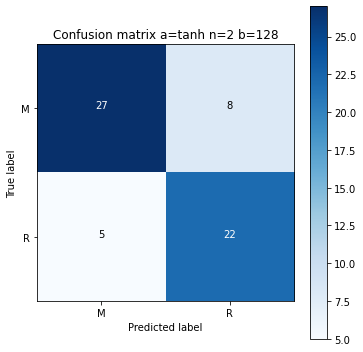

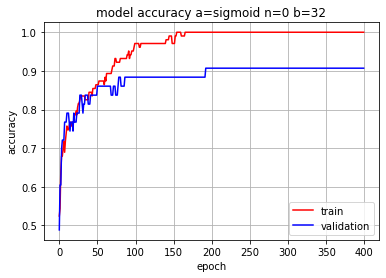

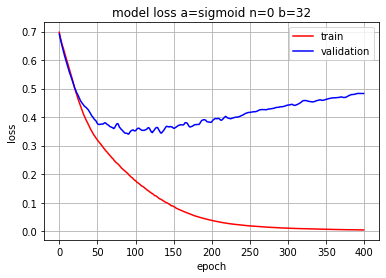

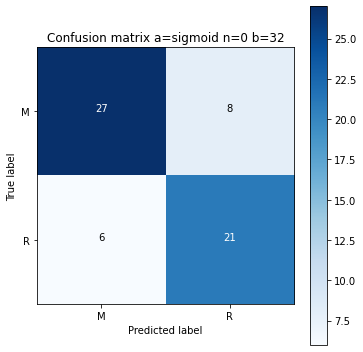

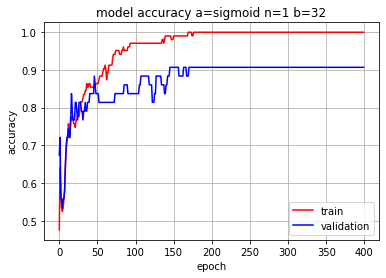

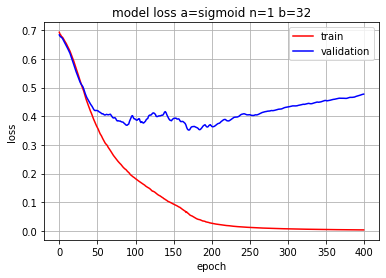

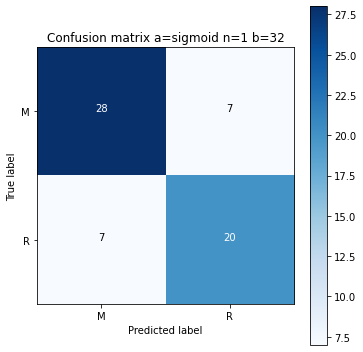

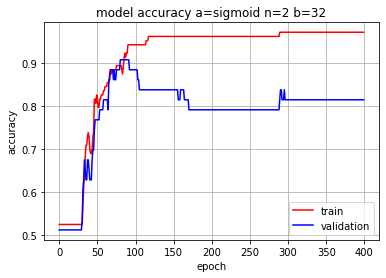

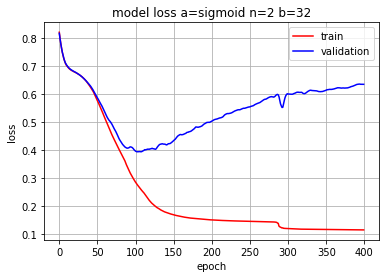

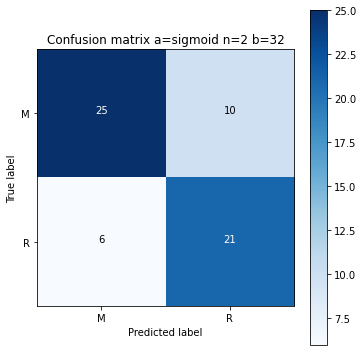

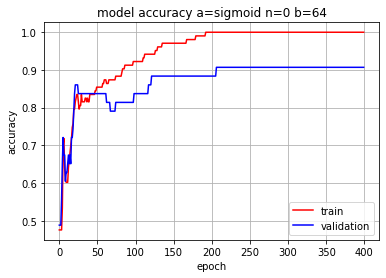

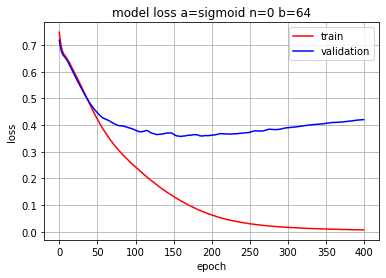

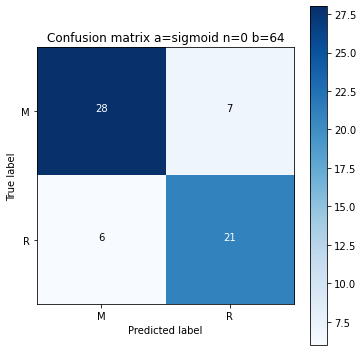

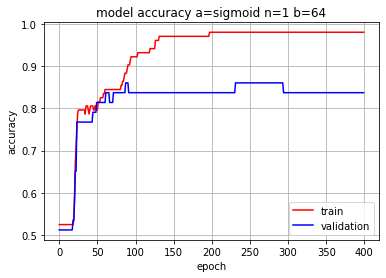

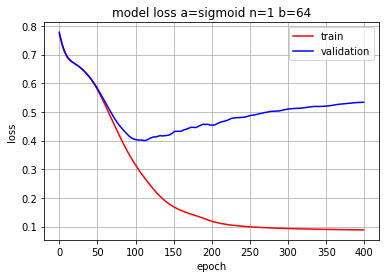

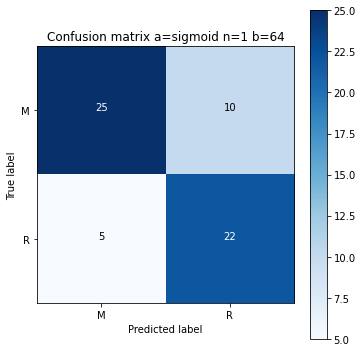

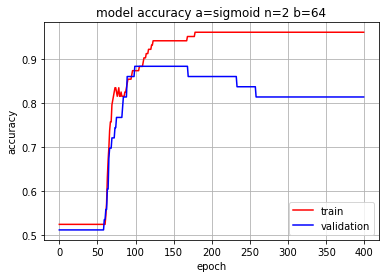

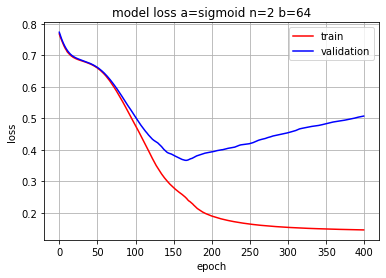

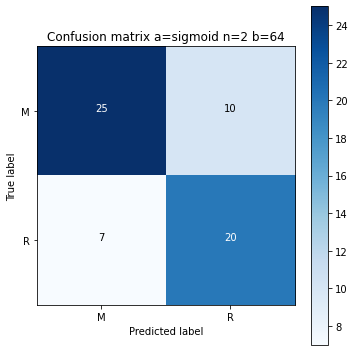

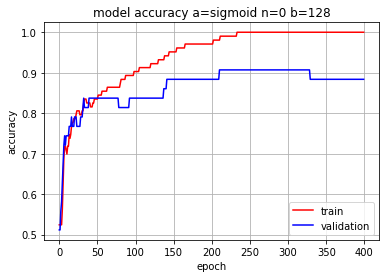

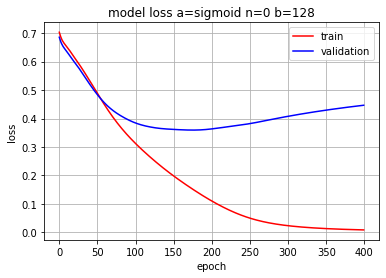

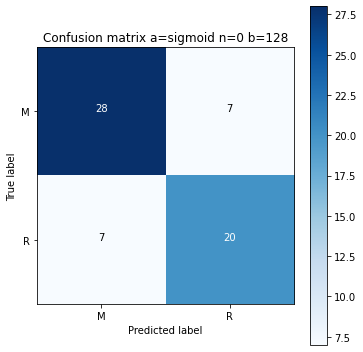

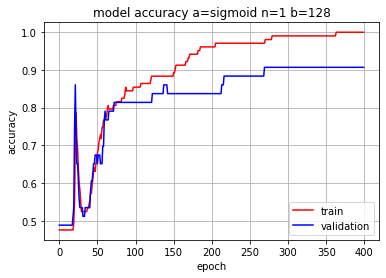

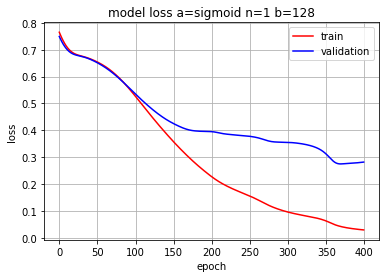

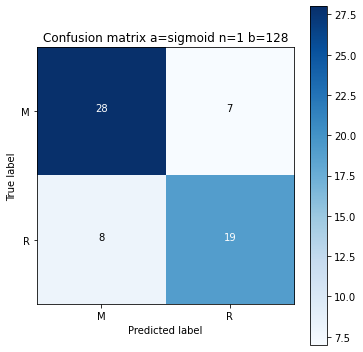

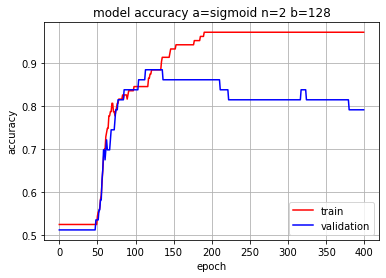

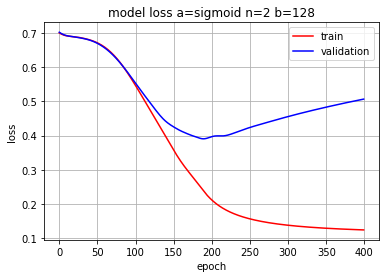

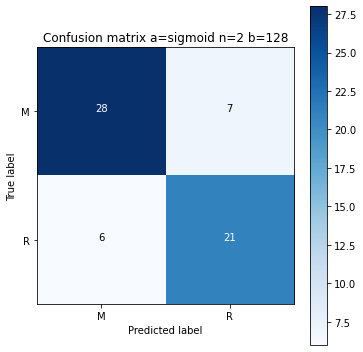

In [28]:
acts = ['relu', 'tanh', 'sigmoid']
batchs = [32, 64, 128]
ns = range(0,3)

for a in acts:
  for b in batchs:
    for n in ns:
      print(a, n, b)
      model = model_base(a, n)
      model = fit_model(model, X_train, y_train, X_val, y_val, "model_best_weightss128.h5", 0, bsize=b, title='a=%s n=%d b=%d'%(a, n, b))
      eval_model(model, X_test, y_test, "model_best_weightss128.h5", 'a=%s n=%d b=%d'%(a, n, b))

- relu 1 64
- activation = relu, layer_num=3, batch_size=64

### using dropout to improve

Model: "sequential_59"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_224 (Dense)            (None, 48)                2928      
_________________________________________________________________
dense_225 (Dense)            (None, 24)                1176      
_________________________________________________________________
dense_226 (Dense)            (None, 12)                300       
_________________________________________________________________
dense_227 (Dense)            (None, 2)                 26        
Total params: 4,430
Trainable params: 4,430
Non-trainable params: 0
_________________________________________________________________
Epoch 1/400
2/2 [==============================] - 1s 222ms/step - loss: 0.8030 - accuracy: 0.4786 - val_loss: 0.7591 - val_accuracy: 0.4419

Epoch 00001: val_loss improved from inf to 0.75913, saving model to model_best_weightss164.h5
Epoch 2/400
2

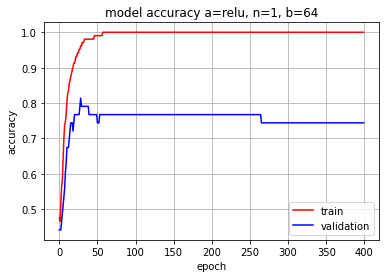

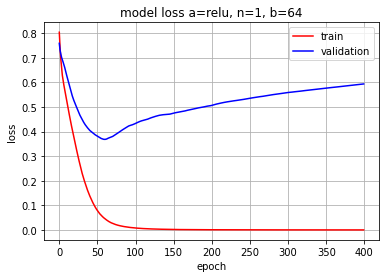

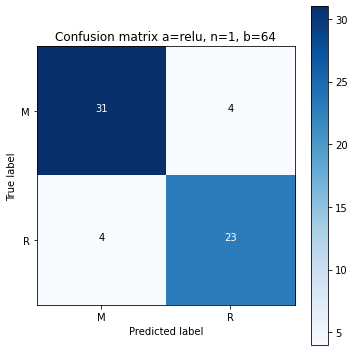

In [53]:
model = model_base('relu', 1)
model = fit_model(model, X_train, y_train, X_val, y_val, "model_best_weightss164.h5", v=1, bsize=64, title='a=relu, n=1, b=64')
eval_model(model, X_test, y_test, "model_best_weightss164.h5", 'a=relu, n=1, b=64')

Epoch 1/400
2/2 [==============================] - 1s 231ms/step - loss: 0.7986 - accuracy: 0.4540 - val_loss: 0.7392 - val_accuracy: 0.3953

Epoch 00001: val_loss improved from inf to 0.73922, saving model to model_best_weightss128i.h5
Epoch 2/400
2/2 [==============================] - 0s 50ms/step - loss: 0.7126 - accuracy: 0.5137 - val_loss: 0.7066 - val_accuracy: 0.5116

Epoch 00002: val_loss improved from 0.73922 to 0.70658, saving model to model_best_weightss128i.h5
Epoch 3/400
2/2 [==============================] - 0s 48ms/step - loss: 0.6949 - accuracy: 0.5564 - val_loss: 0.6801 - val_accuracy: 0.6279

Epoch 00003: val_loss improved from 0.70658 to 0.68007, saving model to model_best_weightss128i.h5
Epoch 4/400
2/2 [==============================] - 0s 50ms/step - loss: 0.6639 - accuracy: 0.5823 - val_loss: 0.6590 - val_accuracy: 0.6744

Epoch 00004: val_loss improved from 0.68007 to 0.65901, saving model to model_best_weightss128i.h5
Epoch 5/400
2/2 [==========================

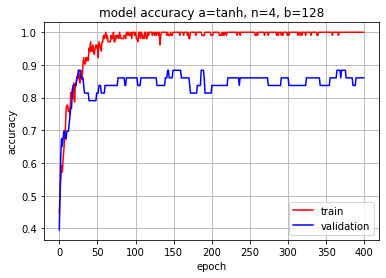

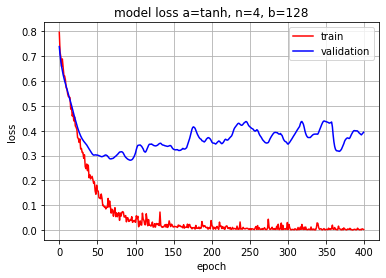

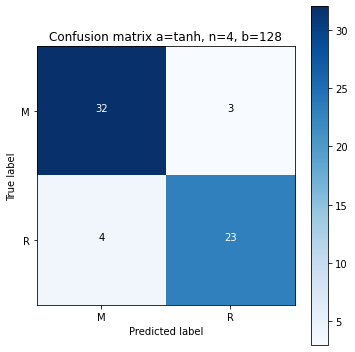

In [61]:
from keras.layers import Dropout
# from keras.wrappers.scikit_learn import KerasClassifier
from keras.constraints import maxnorm

model = Sequential()
model.add(Dropout(0.2, input_shape=(60, )))
model.add(Dense(48, activation='relu'))
model.add(Dense(24, activation='relu'))
model.add(Dense(12, activation='relu'))
model.add(Dense(2, activation='sigmoid'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model = fit_model(model, X_train, y_train, X_val, y_val, "model_best_weightss128i.h5", v=1, bsize=64, title='a=tanh, n=4, b=128')
eval_model(model, X_test, y_test, "model_best_weightss128i.h5", 'a=tanh, n=4, b=128')

### overfit experiment

Epoch 1/400
2/2 [==============================] - 1s 219ms/step - loss: 1.0551 - accuracy: 0.4968 - val_loss: 0.9932 - val_accuracy: 0.5349

Epoch 00001: val_loss improved from inf to 0.99320, saving model to model_best_weightss128.h5
Epoch 2/400
2/2 [==============================] - 0s 55ms/step - loss: 0.9839 - accuracy: 0.5201 - val_loss: 0.9426 - val_accuracy: 0.5349

Epoch 00002: val_loss improved from 0.99320 to 0.94262, saving model to model_best_weightss128.h5
Epoch 3/400
2/2 [==============================] - 0s 60ms/step - loss: 0.9095 - accuracy: 0.5435 - val_loss: 0.8934 - val_accuracy: 0.5581

Epoch 00003: val_loss improved from 0.94262 to 0.89338, saving model to model_best_weightss128.h5
Epoch 4/400
2/2 [==============================] - 0s 57ms/step - loss: 0.8901 - accuracy: 0.5577 - val_loss: 0.8463 - val_accuracy: 0.5581

Epoch 00004: val_loss improved from 0.89338 to 0.84634, saving model to model_best_weightss128.h5
Epoch 5/400
2/2 [==============================

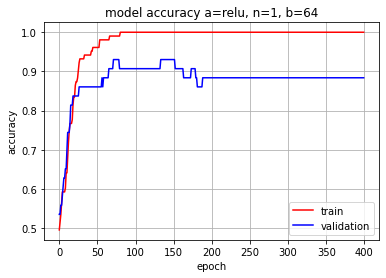

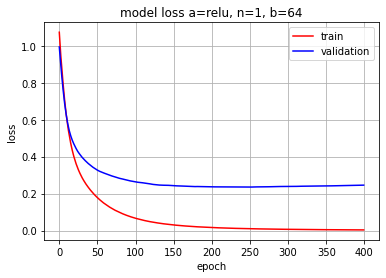

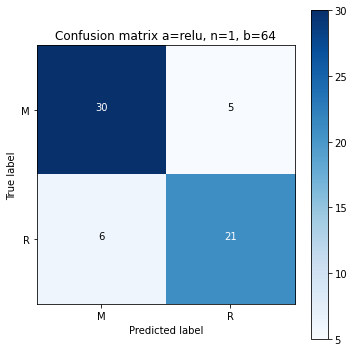

In [63]:
model = Sequential()
model.add(Dense(30, input_dim=60, activation='relu'))
model.add(Dense(2, activation='sigmoid'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model = fit_model(model, X_train, y_train, X_val, y_val, "model_best_weightss128.h5", v=1, bsize=64, title='a=relu, n=1, b=64')
eval_model(model, X_test, y_test, "model_best_weightss128.h5", 'a=relu, n=1, b=64')

Epoch 1/400
2/2 [==============================] - 1s 214ms/step - loss: 0.8700 - accuracy: 0.5214 - val_loss: 0.6720 - val_accuracy: 0.6279

Epoch 00001: val_loss improved from inf to 0.67201, saving model to model_best_weightss128.h5
Epoch 2/400
2/2 [==============================] - 0s 52ms/step - loss: 0.8328 - accuracy: 0.5512 - val_loss: 0.6603 - val_accuracy: 0.6744

Epoch 00002: val_loss improved from 0.67201 to 0.66025, saving model to model_best_weightss128.h5
Epoch 3/400
2/2 [==============================] - 0s 54ms/step - loss: 0.8007 - accuracy: 0.5681 - val_loss: 0.6492 - val_accuracy: 0.6744

Epoch 00003: val_loss improved from 0.66025 to 0.64916, saving model to model_best_weightss128.h5
Epoch 4/400
2/2 [==============================] - 0s 56ms/step - loss: 0.7763 - accuracy: 0.5681 - val_loss: 0.6388 - val_accuracy: 0.7209

Epoch 00004: val_loss improved from 0.64916 to 0.63879, saving model to model_best_weightss128.h5
Epoch 5/400
2/2 [==============================

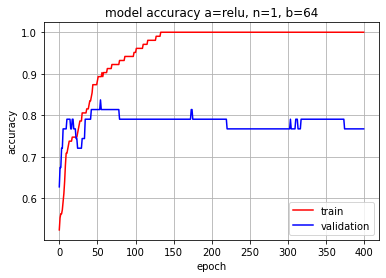

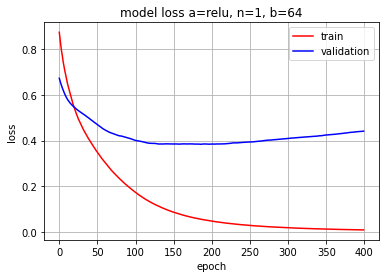

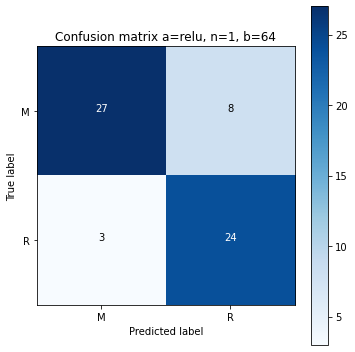

In [64]:
model = Sequential()
model.add(Dense(10, input_dim=60, activation='relu'))
model.add(Dense(2, activation='sigmoid'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model = fit_model(model, X_train, y_train, X_val, y_val, "model_best_weightss128.h5", v=1, bsize=64, title='a=relu, n=1, b=64')
eval_model(model, X_test, y_test, "model_best_weightss128.h5", 'a=relu, n=1, b=64')

Epoch 1/400
2/2 [==============================] - 0s 198ms/step - loss: 0.8401 - accuracy: 0.5616 - val_loss: 0.7424 - val_accuracy: 0.6279

Epoch 00001: val_loss improved from inf to 0.74237, saving model to model_best_weightss128.h5
Epoch 2/400
2/2 [==============================] - 0s 50ms/step - loss: 0.8733 - accuracy: 0.5369 - val_loss: 0.7201 - val_accuracy: 0.6279

Epoch 00002: val_loss improved from 0.74237 to 0.72014, saving model to model_best_weightss128.h5
Epoch 3/400
2/2 [==============================] - 0s 52ms/step - loss: 0.8344 - accuracy: 0.5421 - val_loss: 0.7003 - val_accuracy: 0.6512

Epoch 00003: val_loss improved from 0.72014 to 0.70031, saving model to model_best_weightss128.h5
Epoch 4/400
2/2 [==============================] - 0s 51ms/step - loss: 0.8264 - accuracy: 0.5629 - val_loss: 0.6815 - val_accuracy: 0.6744

Epoch 00004: val_loss improved from 0.70031 to 0.68152, saving model to model_best_weightss128.h5
Epoch 5/400
2/2 [==============================

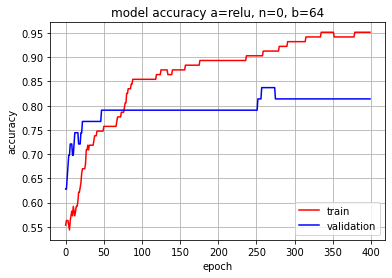

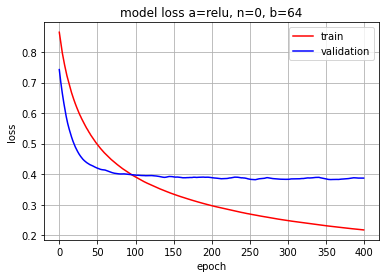

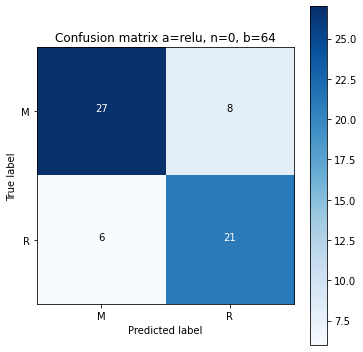

In [65]:
model = Sequential()
model.add(Dense(2, input_dim=60, activation='sigmoid'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model = fit_model(model, X_train, y_train, X_val, y_val, "model_best_weightss128.h5", v=1, bsize=64, title='a=relu, n=0, b=64')
eval_model(model, X_test, y_test, "model_best_weightss128.h5", 'a=relu, n=0, b=64')